In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.special import erf
from sklearn.metrics import f1_score, recall_score, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


# Defining functions

In [ ]:
def oh_encoder_data700k(df, experimento=0, n=400000, removeDuplicates=False):
    df = df.rename(columns={'is_malicious': 'label'})
    df = df.drop(['time'], axis=1)
    features = ['src_user', 'src_comp', 'dst_comp', 'label']
    
    if(removeDuplicates):
        df = df.drop_duplicates()
        print("Tamanho do dataset retirando duplicatas: " + df.size.astype(str))

    df_train = df[features][df.label == 0][0:n]
    #df_test = df[features][df.label == 1]
    df_test = df[features][~df[features].dst_comp.isin(df_train.dst_comp.values) & \
                           ~df[features].src_user.isin(df_train.src_user.values)]
    
    y_test = df_test.label.values
    
    df_train = df_train.drop(['label'], axis=1)
    df_test = df_test.drop(['label'], axis=1)
    
    if(experimento == 1):
      df_train = df_train.drop(['src_comp'], axis=1)
      df_test = df_test.drop(['src_comp'], axis=1)
      features.remove('src_comp')
    elif(experimento == 2):
      df_train = df_train.drop(['src_user'], axis=1)
      df_test = df_test.drop(['src_user'], axis=1)
      features.remove('src_user')
    
    fit = OneHotEncoder().fit(df[features[:-1]])
    
    X_train = fit.transform(df_train.to_numpy()).toarray()
    X_test = fit.transform(df_test.to_numpy()).toarray()
    
    return X_train, X_test, y_test

def oh_encoder_data_unified_auth(df, experimento=0, percentage=0.6, removeDuplicates=False):
    df = df.drop(['time'], axis=1)
    features = ['computer_source', 'user', 'computer_dest', 'label']
    
    if(removeDuplicates):
        df = df.drop_duplicates()
        print("Tamanho do dataset retirando duplicatas: " + df.size.astype(str))

    separator = int(percentage*len(df))

    df_train = df[features][df.label == 0][0:separator]
    #df_test = df[features][df.label == 1]
    df_test = df[features][~df[features].computer_dest.isin(df_train.computer_dest.values) & \
                           ~df[features].user.isin(df_train.user.values)]
    
    y_test = df_test.label.values
    
    df_train = df_train.drop(['label'], axis=1)
    df_test = df_test.drop(['label'], axis=1)
    
    if(experimento == 1):
      df_train = df_train.drop(['computer_source'], axis=1)
      df_test = df_test.drop(['computer_source'], axis=1)
      features.remove('computer_source')
    elif(experimento == 2):
      df_train = df_train.drop(['user'], axis=1)
      df_test = df_test.drop(['user'], axis=1)
      features.remove('user')
    
    fit = OneHotEncoder().fit(df[features[:-1]])
    
    X_train = fit.transform(df_train.to_numpy()).toarray()
    X_test = fit.transform(df_test.to_numpy()).toarray()
    
    return X_train, X_test, y_test

def get_percentile(scores, y_true):
    out_perc = np.size(np.where(y_true==1)) / len(y_true)
    per = np.percentile(scores, 100 * (1 - out_perc))
    return per

def standardizer(X_train, X_test, type='standard'):
    if type == 'standard':
        scaler = StandardScaler().fit(X_train)
    elif type == 'minmax' or type == 'min_max':
        scaler = MinMaxScaler().fit(X_train)
        
    return scaler.transform(X_train), scaler.transform(X_test)

class Lof(LocalOutlierFactor):
    def fit(self, X_train, y=None):
        self.X_train = X_train
        super().fit(X=X_train, y=y)
        return self

    def decision_function(self, X_test):
        return super().decision_function(X_test)

    def predict_proba(self, X_test):
        nof = self.negative_outlier_factor_ * -1
        test_scores = self.decision_function(X_test) * -1
        scaler = MinMaxScaler().fit(nof.reshape(-1, 1))
        proba = scaler.transform(test_scores.reshape(-1, 1))
        return proba.clip(0, 1)

# Handling datasets

In [ ]:
df_700k = pd.read_csv("lanl-comprehensive_700k.csv")

In [ ]:
df_700k.head()

,time,src_user,src_comp,dst_comp,is_malicious
0,1.0,ANONYMOUS LOGON@C586,C1250,C586,0
1,1.0,ANONYMOUS LOGON@C586,C586,C586,0
2,1.0,C1021$@DOM1,C1021,C625,0
3,1.0,C1035$@DOM1,C1035,C586,0
4,1.0,C1035$@DOM1,C586,C586,0


In [ ]:
df_unified_auth = pd.read_csv("lanl-comprehensive-unified-auth.csv")

In [ ]:
df_unified_auth.head()

,time,computer_source,user,computer_dest,label
0,87151,C288750,U451666,C313779,0
1,87451,C288750,U451666,C313779,0
2,100695,C206546,U457678,C639081,0
3,100695,C206546,U457678,C639081,0
4,101274,C206546,U416717,C825721,0


## Base 1 (lanl-comprehensive_700k)

In [ ]:
X_train_b1, X_test_b1, y_test_b1 = oh_encoder_data700k(df_700k, n=30000, removeDuplicates=True)

Tamanho do dataset retirando duplicatas: 178080
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X_train_norm_b1, X_test_norm_b1 = standardizer(X_train_b1, X_test_b1)

## Experimento 1 (lanl-comprehensive_700k)

In [ ]:
X_train_Ex1, X_test_Ex1, y_test_Ex1 = oh_encoder_data700k(df_700k, experimento=1, n=30000, removeDuplicates=True)

Tamanho do dataset retirando duplicatas: 178080
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X_train_norm_Ex1, X_test_norm_Ex1 = standardizer(X_train_Ex1, X_test_Ex1)

## Experimento 2 (lanl-comprehensive_700k)

In [ ]:
X_train_Ex2, X_test_Ex2, y_test_Ex2 = oh_encoder_data700k(df_700k, experimento=2, n=30000, removeDuplicates=True)

Tamanho do dataset retirando duplicatas: 178080
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X_train_norm_Ex2, X_test_norm_Ex2 = standardizer(X_train_Ex2, X_test_Ex2)

## Base 2 (lanl-comprehensive_unified-auth)

In [ ]:
X_train_b2, X_test_b2, y_test_b2 = oh_encoder_data_unified_auth(df_unified_auth)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X_train_norm_b2, X_test_norm_b2 = standardizer(X_train_b2, X_test_b2)

## Experimento 3 (lanl-comprehensive_unified-auth)

In [ ]:
X_train_Ex3, X_test_Ex3, y_test_Ex3 = oh_encoder_data_unified_auth(df_unified_auth, experimento=1)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X_train_norm_Ex3, X_test_norm_Ex3 = standardizer(X_train_Ex3, X_test_Ex3)

## Experimento 4 (lanl-comprehensive_unified-auth)

In [ ]:
X_train_Ex4, X_test_Ex4, y_test_Ex4 = oh_encoder_data_unified_auth(df_unified_auth, experimento=2)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X_train_norm_Ex4, X_test_norm_Ex4 = standardizer(X_train_Ex4, X_test_Ex4)

# Train

## Base 1 (lanl-comprehensive_700k)

In [ ]:
%%time
model_b1 = Lof(n_neighbors=10, novelty= True)
model_b1.fit(X_train_norm_b1)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_b1 = model_b1.predict_proba(X_test_norm_b1)

KernelInterrupted: Execution interrupted by the Jupyter kernel.

## Experimento 1 (lanl-comprehensive_700k)

In [ ]:
%%time
model_Ex1 = Lof(n_neighbors=10, novelty= True)
model_Ex1.fit(X_train_norm_Ex1)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_Ex1 = model_Ex1.predict_proba(X_test_norm_Ex1)

CPU times: user 5min 45s, sys: 17.1 s, total: 6min 2s
Wall time: 4min 8s


## Experimento 2 (lanl-comprehensive_700k)

In [ ]:
%%time
model_Ex2 = Lof(n_neighbors=10, novelty= True)
model_Ex2.fit(X_train_norm_Ex2)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_Ex2 = model_Ex2.predict_proba(X_test_norm_Ex2)

CPU times: user 3min 58s, sys: 14.7 s, total: 4min 13s
Wall time: 2min 56s


## Base 2 (lanl-comprehensive_unified-auth) 

In [ ]:
%%time
model_b2 = Lof(n_neighbors=10, novelty= True)
model_b2.fit(X_train_norm_b2)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_b2 = model_b2.predict_proba(X_test_norm_b2)

CPU times: user 1min 43s, sys: 10.5 s, total: 1min 54s
Wall time: 1min 20s


## Experimento 3 (lanl-comprehensive_unified-auth)

In [ ]:
%%time
model_Ex3 = Lof(n_neighbors=10, novelty= True)
model_Ex3.fit(X_train_norm_Ex3)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_Ex3 = model_Ex3.predict_proba(X_test_norm_Ex3)

CPU times: user 1min 17s, sys: 4.59 s, total: 1min 22s
Wall time: 57.3 s


## Experimento 4 (lanl-comprehensive_unified-auth)

In [ ]:
%%time
model_Ex4 = Lof(n_neighbors=10, novelty= True)
model_Ex4.fit(X_train_norm_Ex4)

#train_scores = model.negative_outlier_factor_ * -1
#test_scores = model.decision_function(X_test_norm) * -1

test_scores_Ex4 = model_Ex4.predict_proba(X_test_norm_Ex4)

CPU times: user 57.4 s, sys: 4.94 s, total: 1min 2s
Wall time: 1min 25s


# Metrics

## Base 1 (lanl-comprehensive_700k)

In [ ]:
roc_b1 = roc_auc_score(y_test_b1, test_scores_b1)
ap_b1 = average_precision_score(y_test_b1, test_scores_b1)

print(f"ROC score: {roc_b1}")
print(f"Average precision score: {ap_b1}")

ROC score: 0.2916117698726394
Average precision score: 0.02729218759753111


In [ ]:
per = get_percentile(test_scores_b1, y_test_b1.astype(int))    
y_pred_b1 = (test_scores_b1>=per)

roc_score_auc_b1 = roc_auc_score(y_test_b1.astype(int), y_pred_b1.astype(int)) 
average_precision_b1 = average_precision_score(y_test_b1.astype(int), y_pred_b1.astype(int))

precision_b1, recall_b1, f1_b1, _ = precision_recall_fscore_support(y_test_b1.astype(int),
                                                            y_pred_b1.astype(int),
                                                            average='binary')
print(f"F1 {f1_b1}")
print(f"Recall: {recall_b1}")

F1 0.0
Recall: 0.0


In [ ]:
tn_b1, fp_b1, fn_b1, tp_b1 = confusion_matrix(y_test_b1, y_pred_b1).ravel()

In [ ]:
print(f"True positives: {tp_b1}")
print(f"False positives: {fp_b1}")

True positives: 0
False positives: 36


In [ ]:
import pickle

metrics = {'F1':f1_b1,'Average Precision':ap_b1,'Recall':recall_b1,'ROC value':roc_b1}
tp_fp = {'tp':tp_b1,'fp':fp_b1}

pickle.dump((metrics,tp_fp), open("resultsB1.pkl", "wb"))

## Experimento 1 (lanl-comprehensive_700k)

In [ ]:
roc_Ex1 = roc_auc_score(y_test_Ex1, test_scores_Ex1)
ap_Ex1 = average_precision_score(y_test_Ex1, test_scores_Ex1)

print(f"ROC score: {roc_Ex1}")
print(f"Average precision score: {ap_Ex1}")

ROC score: 0.5
Average precision score: 0.8910891089108911


In [ ]:
per = get_percentile(test_scores_Ex1, y_test_Ex1.astype(int))    
y_pred_Ex1 = (test_scores_Ex1>=per)

roc_score_auc_Ex1 = roc_auc_score(y_test_Ex1.astype(int), y_pred_Ex1.astype(int)) 
average_precision_Ex1 = average_precision_score(y_test_Ex1.astype(int), y_pred_Ex1.astype(int))

precision_Ex1, recall_Ex1, f1_Ex1, _ = precision_recall_fscore_support(y_test_Ex1.astype(int),
                                                            y_pred_Ex1.astype(int),
                                                            average='binary')
print(f"F1 {f1_Ex1}")
print(f"Recall: {recall_Ex1}")

F1 0.9424083769633509
Recall: 1.0


In [ ]:
tn_Ex1, fp_Ex1, fn_Ex1, tp_Ex1 = confusion_matrix(y_test_Ex1, y_pred_Ex1).ravel()

In [ ]:
print(f"True positives: {tp_Ex1}")
print(f"False positives: {fp_Ex1}")

True positives: 90
False positives: 11


In [ ]:
import pickle

metrics = {'F1':f1_Ex1,'Average Precision':ap_Ex1,'Recall':recall_Ex1,'ROC value':roc_Ex1}
tp_fp = {'tp':tp_Ex1,'fp':fp_Ex1}

pickle.dump((metrics,tp_fp), open("results1NoDuplicates.pkl", "wb"))

## Experimento 2 (lanl-comprehensive_700k)

In [ ]:
roc_Ex2 = roc_auc_score(y_test_Ex2, test_scores_Ex2)
ap_Ex2 = average_precision_score(y_test_Ex2, test_scores_Ex2)

print(f"ROC score: {roc_Ex2}")
print(f"Average precision score: {ap_Ex2}")

ROC score: 0.18181818181818177
Average precision score: 0.8982236154649949


In [ ]:
per = get_percentile(test_scores_Ex2, y_test_Ex2.astype(int))    
y_pred_Ex2 = (test_scores_Ex2>=per)

roc_score_auc_Ex2 = roc_auc_score(y_test_Ex2.astype(int), y_pred_Ex2.astype(int)) 
average_precision_Ex2 = average_precision_score(y_test_Ex2.astype(int), y_pred_Ex2.astype(int))

precision_Ex2, recall_Ex2, f1_Ex2, _ = precision_recall_fscore_support(y_test_Ex2.astype(int),
                                                            y_pred_Ex2.astype(int),
                                                            average='binary')
print(f"F1 {f1_Ex2}")
print(f"Recall: {recall_Ex2}")

F1 0.9523809523809523
Recall: 1.0


In [ ]:
tn_Ex2, fp_Ex2, fn_Ex2, tp_Ex2 = confusion_matrix(y_test_Ex2, y_pred_Ex2).ravel()

In [ ]:
print(f"True positives: {tp_Ex2}")
print(f"False positives: {fp_Ex2}")

True positives: 90
False positives: 9


In [ ]:
import pickle

metrics = {'F1':f1_Ex2,'Average Precision':ap_Ex2,'Recall':recall_Ex2,'ROC value':roc_Ex2}
tp_fp = {'tp':tp_Ex2,'fp':fp_Ex2}

pickle.dump((metrics,tp_fp), open("results2NoDuplicates.pkl", "wb"))

## Base 2 (lanl-comprehensive_unified-auth)

In [ ]:
roc_b2 = roc_auc_score(y_test_b2, test_scores_b2)
ap_b2 = average_precision_score(y_test_b2, test_scores_b2)

print(f"ROC score: {roc_b2}")
print(f"Average precision score: {ap_b2}")

In [ ]:
per = get_percentile(test_scores_b2, y_test_b2.astype(int))    
y_pred_b2 = (test_scores_b2>=per)

roc_score_auc_b2 = roc_auc_score(y_test_b2.astype(int), y_pred_b2.astype(int)) 
average_precision_b2 = average_precision_score(y_test_b2.astype(int), y_pred_b2.astype(int))

precision_b2, recall_b2, f1_b2, _ = precision_recall_fscore_support(y_test_b2.astype(int),
                                                            y_pred_b2.astype(int),
                                                            average='binary')
print(f"F1 {f1_b2}")
print(f"Recall: {recall_b2}")

In [ ]:
tn_b2, fp_b2, fn_b2, tp_b2 = confusion_matrix(y_test_b2, y_pred_b2).ravel()

In [ ]:
print(f"True positives: {tp_b2}")
print(f"False positives: {fp_b2}")

In [ ]:
total_positives = np.size(np.where(y_test_b2.astype(int)==1))
tpr_b2 = tp_b2/total_positives
tpr_b2
total_positives

In [ ]:
import pickle

metrics = {'F1':f1_b2,'Average Precision':ap_b2,'Recall':recall_b2,'ROC value':roc_b2}
tp_fp = {'tp':tp_b2,'fp':fp_b2}

pickle.dump((metrics,tp_fp), open("resultsB2.pkl", "wb"))

## Experimento 3 (lanl-comprehensive_unified-auth)

In [ ]:
roc_Ex3 = roc_auc_score(y_test_Ex3, test_scores_Ex3)
ap_Ex3 = average_precision_score(y_test_Ex3, test_scores_Ex3)

print(f"ROC score: {roc_Ex3}")
print(f"Average precision score: {ap_Ex3}")

ROC score: 0.5
Average precision score: 0.031746031746031744


In [ ]:
per = get_percentile(test_scores_Ex3, y_test_Ex3.astype(int))    
y_pred_Ex3 = (test_scores_Ex3>=per)

roc_score_auc_Ex3 = roc_auc_score(y_test_Ex3.astype(int), y_pred_Ex3.astype(int)) 
average_precision_Ex3 = average_precision_score(y_test_Ex3.astype(int), y_pred_Ex3.astype(int))

precision_Ex3, recall_Ex3, f1_Ex3, _ = precision_recall_fscore_support(y_test_Ex3.astype(int),
                                                            y_pred_Ex3.astype(int),
                                                            average='binary')
print(f"F1 {f1_Ex3}")
print(f"Recall: {recall_Ex3}")

F1 0.06153846153846154
Recall: 1.0


In [ ]:
tn_Ex3, fp_Ex3, fn_Ex3, tp_Ex3 = confusion_matrix(y_test_Ex3, y_pred_Ex3).ravel()

In [ ]:
print(f"True positives: {tp_Ex3}")
print(f"False positives: {fp_Ex3}")

True positives: 14
False positives: 427


In [ ]:
total_positives = np.size(np.where(y_test_Ex3.astype(int)==1))
tpr_Ex3 = tp_Ex3/total_positives
tpr_Ex3
total_positives

In [ ]:
import pickle

metrics = {'F1':f1_Ex3,'Average Precision':ap_Ex3,'Recall':recall_Ex3,'ROC value':roc_Ex3}
tp_fp = {'tp':tp_Ex3,'fp':fp_Ex3}

pickle.dump((metrics,tp_fp), open("resultsExp3.pkl", "wb"))

### Graphic representation

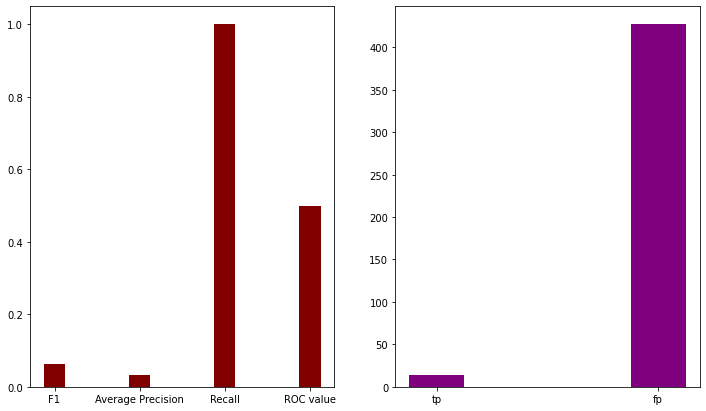

In [ ]:
import pickle

metrics, tp_fp = pickle.load( open( "resultsExp3.pkl", "rb" ) )

fig, axs = plt.subplots(1,2,figsize =(12, 7))

barWidth = 0.25
br1 = np.arange(len(metrics))
br2 = np.arange(len(tp_fp))

axs.flat[0].bar(br1,metrics.values(),color='maroon',width = barWidth)
axs.flat[0].set_xticks([r for r in range(len(metrics))],
        metrics.keys())

axs.flat[1].bar(br2,tp_fp.values(),color='purple',width = barWidth)
axs.flat[1].set_xticks([r for r in range(len(tp_fp))],
        tp_fp.keys())

## Experimento 4 (lanl-comprehensive_unified-auth)

In [ ]:
ap_Ex4 = average_precision_score(y_test_Ex4, test_scores_Ex4)
roc_Ex4 = roc_auc_score(y_test_Ex4, test_scores_Ex4)

print(f"ROC score: {roc_Ex4}")
print(f"Average precision score: {ap_Ex4}")

ROC score: 0.9016393442622951
Average precision score: 0.25


In [ ]:
per = get_percentile(test_scores_Ex4, y_test_Ex4.astype(int))    
y_pred_Ex4 = (test_scores_Ex4>=per)

roc_score_auc_Ex4 = roc_auc_score(y_test_Ex4.astype(int), y_pred_Ex4.astype(int)) 
average_precision_Ex4 = average_precision_score(y_test_Ex4.astype(int), y_pred_Ex4.astype(int))

precision_Ex4, recall_Ex4, f1_Ex4, _ = precision_recall_fscore_support(y_test_Ex4.astype(int),
                                                            y_pred_Ex4.astype(int),
                                                            average='binary')
print(f"F1 {f1_Ex4}")
print(f"Recall: {recall_Ex4}")

F1 0.0
Recall: 0.0


In [ ]:
tn_Ex4, fp_Ex4, fn_Ex4, tp_Ex4 = confusion_matrix(y_test_Ex4, y_pred_Ex4).ravel()

In [ ]:
print(f"True positives: {tp_Ex4}")
print(f"False positives: {fp_Ex4}")

True positives: 0
False positives: 15


In [ ]:
total_positives = np.size(np.where(y_test_Ex4.astype(int)==1))
tpr_Ex4 = tp_Ex4/total_positives
tpr_Ex4
total_positives

14

In [ ]:
import pickle

metrics = {'F1':f1_Ex4,'Average Precision':ap_Ex4,'Recall':recall_Ex4,'ROC value':roc_Ex4}
tpr_fp = {'tp':tpr_Ex4,'fp':fpr_Ex4}

pickle.dump((metrics,tp_fp), open("resultsExp4.pkl", "wb"))

### Graphic representation

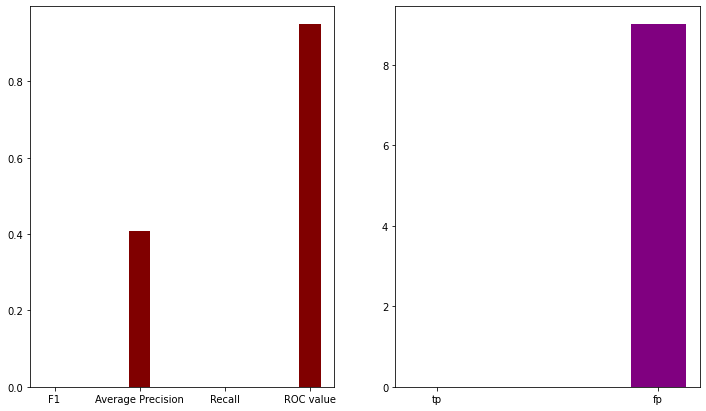

In [ ]:
import pickle

metrics, tp_fp = pickle.load( open( "resultsExp4.pkl", "rb" ) )

fig, axs = plt.subplots(1,2,figsize =(12, 7))

barWidth = 0.25
br1 = np.arange(len(metrics))
br2 = np.arange(len(tp_fp))

axs.flat[0].bar(br1,metrics.values(),color='maroon',width = barWidth)
axs.flat[0].set_xticks([r for r in range(len(metrics))],
        metrics.keys())

axs.flat[1].bar(br2,tp_fp.values(),color='purple',width = barWidth)
axs.flat[1].set_xticks([r for r in range(len(tp_fp))],
        tp_fp.keys())

## Graphic representation

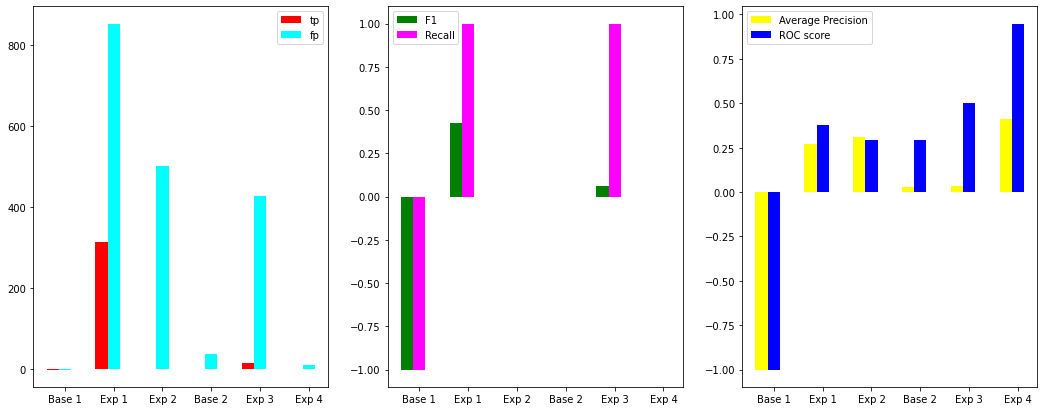

In [ ]:
import pickle

metricsB1, tpr_fprB1 = pickle.load( open( "resultsB1.pkl", "rb" ) )
metrics1, tpr_fpr1 = pickle.load( open( "resultsExp1.pkl", "rb" ) )
metrics2, tpr_fpr2 = pickle.load( open( "resultsExp2.pkl", "rb" ) )

metricsB2, tpr_fprB2 = pickle.load( open( "resultsB2.pkl", "rb" ) )
metrics3, tpr_fpr3 = pickle.load( open( "resultsExp3.pkl", "rb" ) )
metrics4, tpr_fpr4 = pickle.load( open( "resultsExp4.pkl", "rb" ) )


experimentos = ['Base 1','Exp 1','Exp 2','Base 2','Exp 3','Exp 4' ]


tps = [tpr_fprB1['tp'],tpr_fpr1['tp'],tpr_fpr2['tp'],tpr_fprB2['tp'],tpr_fpr3['tp'],tpr_fpr4['tp']]
fps = [tpr_fprB1['fp'],tpr_fpr1['fp'],tpr_fpr2['fp'],tpr_fprB2['fp'],tpr_fpr3['fp'],tpr_fpr4['fp']]

f1s = [metricsB1['F1'],metrics1['F1'],metrics2['F1'],metricsB2['F1'],metrics3['F1'],metrics4['F1']]
recalls = [metricsB1['Recall'],metrics1['Recall'],metrics2['Recall'],metricsB2['Recall'],metrics3['Recall'],metrics4['Recall']]
aps = [metricsB1['Average Precision'],metrics1['Average Precision'],metrics2['Average Precision'],metricsB2['Average Precision'],metrics3['Average Precision'],metrics4['Average Precision']]
rocs = [metricsB1['ROC value'],metrics1['ROC value'],metrics2['ROC value'],metricsB2['ROC value'],metrics3['ROC value'],metrics4['ROC value']]


fig, axs = plt.subplots(1,3,sharex=True,figsize =(18, 7))

barWidth = 0.25
br1 = np.arange(len(experimentos))
br2 = [x + barWidth for x in br1]

axs.flat[0].bar(br1,tps,color='red',width = barWidth,label="tp")
axs.flat[0].bar(br2,fps,color='cyan',width = barWidth,label="fp")
axs.flat[0].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[0].legend()

axs.flat[1].bar(br1,f1s,color='green',width = barWidth,label="F1")
axs.flat[1].bar(br2,recalls,color='magenta',width = barWidth,label="Recall")
axs.flat[1].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[1].legend()

axs.flat[2].bar(br1,aps,color='yellow',width = barWidth,label="Average Precision")
axs.flat[2].bar(br2,rocs,color='blue',width = barWidth,label="ROC score")
axs.flat[2].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[2].legend()

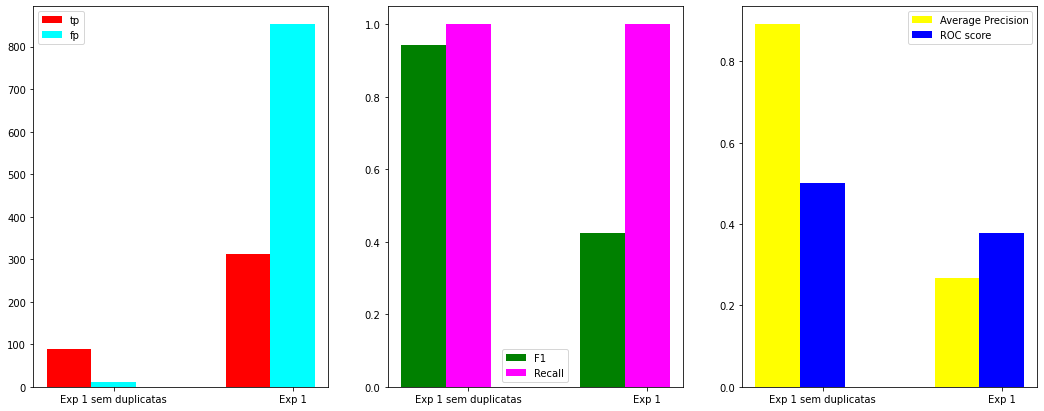

In [ ]:
import pickle

metrics1_noDuplicates, tp_fp1_noDuplicates = pickle.load( open( "results1NoDuplicates.pkl", "rb" ) )
metrics1, tp_fp1 = pickle.load( open( "resultsExp1.pkl", "rb" ) )

experimentos = ['Exp 1 sem duplicatas','Exp 1']


tps = [tp_fp1_noDuplicates['tp'],tp_fp1['tp']]
fps = [tp_fp1_noDuplicates['fp'],tp_fp1['fp']]

f1s = [metrics1_noDuplicates['F1'],metrics1['F1']]
recalls = [metrics1_noDuplicates['Recall'],metrics1['Recall']]
aps = [metrics1_noDuplicates['Average Precision'],metrics1['Average Precision']]
rocs = [metrics1_noDuplicates['ROC value'],metrics1['ROC value']]


fig, axs = plt.subplots(1,3,sharex=True,figsize =(18, 7))

barWidth = 0.25
br1 = np.arange(len(experimentos))
br2 = [x + barWidth for x in br1]

axs.flat[0].bar(br1,tps,color='red',width = barWidth,label="tp")
axs.flat[0].bar(br2,fps,color='cyan',width = barWidth,label="fp")
axs.flat[0].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[0].legend()

axs.flat[1].bar(br1,f1s,color='green',width = barWidth,label="F1")
axs.flat[1].bar(br2,recalls,color='magenta',width = barWidth,label="Recall")
axs.flat[1].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[1].legend()

axs.flat[2].bar(br1,aps,color='yellow',width = barWidth,label="Average Precision")
axs.flat[2].bar(br2,rocs,color='blue',width = barWidth,label="ROC score")
axs.flat[2].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[2].legend()

plt.savefig('Comparacao-com-e-sem-duplicatas-Exp1.png')

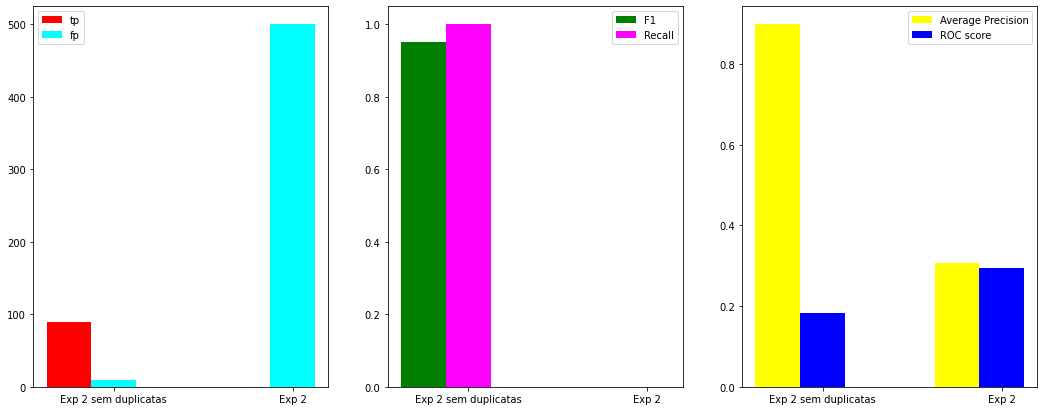

In [ ]:
import pickle

metrics_noDuplicates, tp_fp_noDuplicates = pickle.load( open( "results2NoDuplicates.pkl", "rb" ) )
metrics, tp_fp = pickle.load( open( "resultsExp2.pkl", "rb" ) )

experimentos = ['Exp 2 sem duplicatas','Exp 2']


tps = [tp_fp_noDuplicates['tp'],tp_fp['tp']]
fps = [tp_fp_noDuplicates['fp'],tp_fp['fp']]

f1s = [metrics_noDuplicates['F1'],metrics['F1']]
recalls = [metrics_noDuplicates['Recall'],metrics['Recall']]
aps = [metrics_noDuplicates['Average Precision'],metrics['Average Precision']]
rocs = [metrics_noDuplicates['ROC value'],metrics['ROC value']]


fig, axs = plt.subplots(1,3,sharex=True,figsize =(18, 7))

barWidth = 0.25
br1 = np.arange(len(experimentos))
br2 = [x + barWidth for x in br1]

axs.flat[0].bar(br1,tps,color='red',width = barWidth,label="tp")
axs.flat[0].bar(br2,fps,color='cyan',width = barWidth,label="fp")
axs.flat[0].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[0].legend()

axs.flat[1].bar(br1,f1s,color='green',width = barWidth,label="F1")
axs.flat[1].bar(br2,recalls,color='magenta',width = barWidth,label="Recall")
axs.flat[1].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[1].legend()

axs.flat[2].bar(br1,aps,color='yellow',width = barWidth,label="Average Precision")
axs.flat[2].bar(br2,rocs,color='blue',width = barWidth,label="ROC score")
axs.flat[2].set_xticks([r + barWidth for r in range(len(experimentos))],
        experimentos)
axs.flat[2].legend()

plt.savefig('Comparacao-com-e-sem-duplicatas-Exp2.png')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=829ecfd7-68c1-413f-9cfd-724b1a20fa16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>